In [1]:
from datasets_ImageNet import ImageNet_dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dataset = ImageNet_dataset(dataset_folder='/data/ILSVRC2012', split='train', image_size = (256, 256), slurm=False)

train_dataloader = DataLoader(
            train_dataset,
            batch_size=4,
            num_workers=2,
            pin_memory=True,
            shuffle=True,
            drop_last=True
)

/home/mkkim/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
import torch
import torch.nn as nn 

In [3]:
from compressai.layers import subpel_conv3x3, ResidualBlockWithStride
from compressai.layers.gdn import GDN

class ResBlock_complexNumber(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1).type(torch.complex64)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1).type(torch.complex64)
        
        if in_dim != out_dim:
            self.skip = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1, padding=0).type(torch.complex64)
        else:
            self.skip = None
    
    def forward(self, x):
        
        identity = x

        out = self.conv1(x)
        out.real = self.leaky_relu(out.real)
        out = self.conv2(out)
        out.real = self.leaky_relu(out.real)

        if self.skip is not None:
            identity = self.skip(x)

        out = out + identity
        return out


class ResBlock_Upsample_complexNumber(nn.Module):
    def __init__(self, in_dim, out_dim, upsample=2):
        super().__init__()
        
        self.subpel_conv = subpel_conv3x3(in_dim, out_dim, upsample).type(torch.complex64)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1).type(torch.complex64)
        self.igdn = GDN(out_dim, inverse=True)
        self.upsample = subpel_conv3x3(in_dim, out_dim, upsample).type(torch.complex64)
        
    def forward(self, x):
        
        identity = x
        
        out = self.subpel_conv(x)
        out.real = self.leaky_relu(out.real)
        out = self.conv(out)
        
        print(out.real.size())
        
        out.real = self.igdn(out.real)
        identity = self.upsample(x)
        out += identity
        return out

class ResBlock_Downsample_complexNumber(nn.Module):
    def __init__(self, in_dim, out_dim, downsample=2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1).type(torch.complex64)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1).type(torch.complex64)
        self.gdn = GDN(out_dim)
        if downsample != 1 or in_dim != out_dim:
            self.skip = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=2, padding=0).type(torch.complex64)
        else:
            self.skip = None

        
    def forward(self, x):
        
        identity = x
        out = self.conv1(x)
        out.real = self.leaky_relu(out.real)
        out = self.conv2(out)
        out.real = self.gdn(out.real)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        return out

In [4]:
images = next(iter(train_dataloader))

In [5]:
'''
Author: Cassini Wei
Date: 2023/2/16
'''

import torch
from torch import Tensor
from typing import Tuple


### Ideal low-pass
def _get_center_distance(size: Tuple[int], device: str = 'cpu') -> Tensor:
    """Compute the distance of each matrix element to the center.

    Args:
        size (Tuple[int]): [m, n].
        device (str, optional): cpu/cuda. Defaults to 'cpu'.

    Returns:
        Tensor: [m, n].
    """    
    m, n = size
    i_ind = torch.tile(
                torch.tensor([[[i]] for i in range(m)], device=device),
                dims=[1, n, 1]).float()  # [m, n, 1]
    j_ind = torch.tile(
                torch.tensor([[[i] for i in range(n)]], device=device),
                dims=[m, 1, 1]).float()  # [m, n, 1]
    ij_ind = torch.cat([i_ind, j_ind], dim=-1)  # [m, n, 2]
    ij_ind = ij_ind.reshape([m * n, 1, 2])  # [m * n, 1, 2]
    center_ij = torch.tensor(((m - 1) / 2, (n - 1) / 2), device=device).reshape(1, 2)
    center_ij = torch.tile(center_ij, dims=[m * n, 1, 1])
    dist = torch.cdist(ij_ind, center_ij, p=2).reshape([m, n])
    return dist


def _get_ideal_weights(size: Tuple[int], D0: int, lowpass: bool = True, device: str = 'cpu') -> Tensor:
    """Get H(u, v) of ideal bandpass filter.

    Args:
        size (Tuple[int]): [H, W].
        D0 (int): The cutoff frequency.
        lowpass (bool): True for low-pass filter, otherwise for high-pass filter. Defaults to True.
        device (str, optional): cpu/cuda. Defaults to 'cpu'.

    Returns:
        Tensor: [H, W].
    """    
    center_distance = _get_center_distance(size, device)
    center_distance[center_distance > D0] = -1
    center_distance[center_distance != -1] = 1
    if lowpass is True:
        center_distance[center_distance == -1] = 0
    else:
        center_distance[center_distance == 1] = 0
        center_distance[center_distance == -1] = 1
    return center_distance


def _to_freq(image: Tensor) -> Tensor:
    """Convert from spatial domain to frequency domain.

    Args:
        image (Tensor): [B, C, H, W].

    Returns:
        Tensor: [B, C, H, W]
    """    
    img_fft = torch.fft.fft2(image)
    img_fft_shift = torch.fft.fftshift(img_fft)
    return img_fft_shift


def _to_space(image_fft: Tensor) -> Tensor:
    """Convert from frequency domain to spatial domain.

    Args:
        image_fft (Tensor): [B, C, H, W].

    Returns:
        Tensor: [B, C, H, W].
    """    
    img_ifft_shift = torch.fft.ifftshift(image_fft)
    img_ifft = torch.fft.ifft2(img_ifft_shift)
    img = img_ifft.real.clamp(0, 1)
    return img


def ideal_bandpass(image: Tensor, D0: int, lowpass: bool = True) -> Tensor:
    """Low-pass filter for images.

    Args:
        image (Tensor): [B, C, H, W].
        D0 (int): Cutoff frequency.
        lowpass (bool): True for low-pass filter, otherwise for high-pass filter. Defaults to True.

    Returns:
        Tensor: [B, C, H, W].
    """    
    img_fft = _to_freq(image)
    weights = _get_ideal_weights(img_fft.shape[-2:], D0=D0, lowpass=lowpass, device=image.device)
    img_fft = img_fft * weights
    img = _to_space(img_fft)
    
    return img

def ideal_bandpass_freq_domain(image: Tensor, D0: int, lowpass: bool = True) -> Tensor:
    """Low-pass filter for images.

    Args:
        image (Tensor): [B, C, H, W].
        D0 (int): Cutoff frequency.
        lowpass (bool): True for low-pass filter, otherwise for high-pass filter. Defaults to True.

    Returns:
        Tensor: [B, C, H, W].
    """    
    img_fft = _to_freq(image)
    weights = _get_ideal_weights(img_fft.shape[-2:], D0=D0, lowpass=lowpass, device=image.device)
    img_fft = img_fft * weights
    
    return img_fft

In [6]:
cutoff = min(images.size(-2), images.size(-1)) // 16

fft_img_lowpass = ideal_bandpass_freq_domain(images, cutoff, lowpass = True)
fft_img_highpass = ideal_bandpass_freq_domain(images, cutoff, lowpass = False)

img_lowpass = _to_space(fft_img_lowpass)
img_highpass = _to_space(fft_img_highpass)

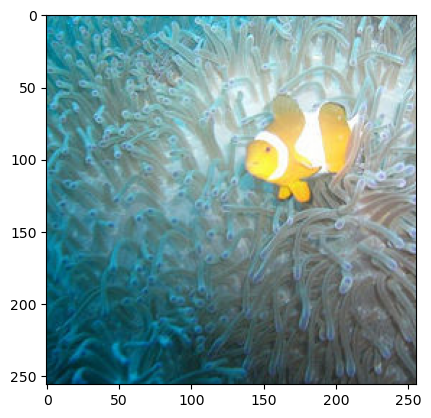

In [8]:
recon_images = _to_space(fft_img_lowpass + fft_img_highpass)

plt.imshow(recon_images[0].permute(1,2,0))

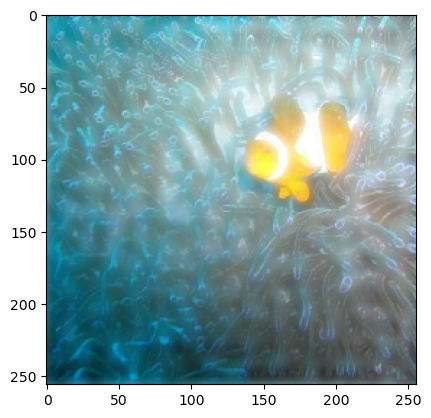

: 

In [9]:
plt.imshow((img_lowpass + img_highpass)[0].permute(1,2,0).clamp(0,1))

In [7]:
img_lowpass + img_highpass

tensor([[[[0.1020, 0.1216, 0.1288,  ..., 0.0521, 0.0612, 0.0741],
          [0.0941, 0.1294, 0.1294,  ..., 0.0498, 0.0582, 0.0700],
          [0.1176, 0.0969, 0.1333,  ..., 0.0485, 0.0562, 0.0671],
          ...,
          [0.1529, 0.1608, 0.1647,  ..., 0.0706, 0.0737, 0.0903],
          [0.1647, 0.1686, 0.1725,  ..., 0.0745, 0.0706, 0.0847],
          [0.1647, 0.1647, 0.1725,  ..., 0.0745, 0.0745, 0.0791]],

         [[0.0876, 0.1036, 0.1206,  ..., 0.0546, 0.0626, 0.0737],
          [0.0798, 0.1098, 0.1101,  ..., 0.0499, 0.0571, 0.0672],
          [0.1059, 0.0869, 0.1333,  ..., 0.0462, 0.0528, 0.0620],
          ...,
          [0.1569, 0.1647, 0.1686,  ..., 0.0745, 0.0801, 0.0948],
          [0.1686, 0.1725, 0.1765,  ..., 0.0784, 0.0746, 0.0880],
          [0.1686, 0.1608, 0.1686,  ..., 0.0784, 0.0784, 0.0808]],

         [[0.0786, 0.0980, 0.1169,  ..., 0.0456, 0.0527, 0.0637],
          [0.0745, 0.1255, 0.1059,  ..., 0.0405, 0.0463, 0.0555],
          [0.0784, 0.0726, 0.1020,  ..., 0

In [12]:
fft_img_highpass_sep = torch.view_as_real(fft_img_highpass)
img_highpass_sep_real = fft_img_highpass_sep[:,:,:,:,0]
img_highpass_sep_img = fft_img_highpass_sep[:,:,:,:,1]

In [17]:
img_highpass_sep_real.min(), img_highpass_sep_real.max()

(tensor(-594.1335), tensor(642.9263))

In [15]:
img_highpass_sep_img.min(), img_highpass_sep_img.max()

(tensor(-1066.7080), tensor(1066.7080))

In [60]:
test_img_highpass_sep_real = img_highpass_sep_real.clone()

In [61]:
test_img_highpass_sep_real = test_img_highpass_sep_real - img_highpass_sep_real.min() 
test_img_highpass_sep_real = test_img_highpass_sep_real / (img_highpass_sep_real.max() - img_highpass_sep_real.min())

In [62]:
test_img_highpass_sep_real.min(), test_img_highpass_sep_real.max()

(tensor(0.), tensor(1.))

In [63]:
test_img_highpass_sep_real = test_img_highpass_sep_real * (img_highpass_sep_real.max() - img_highpass_sep_real.min())
test_img_highpass_sep_real = test_img_highpass_sep_real + img_highpass_sep_real.min() 

In [43]:
(test_img_highpass_sep_real - img_highpass_sep_real.min()).min()

tensor(0.)

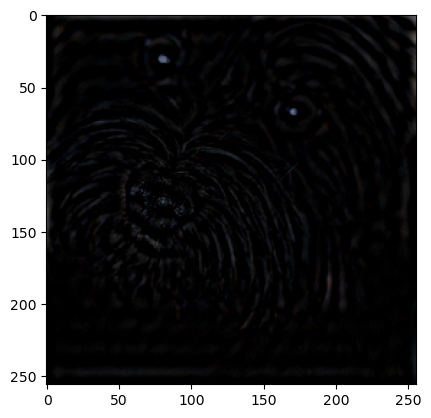

In [8]:
plt.imshow(img_highpass[0].permute(1,2,0))

In [20]:
img_highpass[img_highpass > 0.1]

torch.Size([59010])

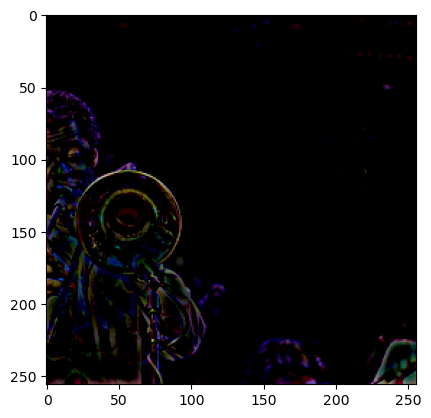

In [18]:
plt.imshow(torch.where(img_highpass > 0.1, img_highpass, 0.0)[3].permute(1,2,0))

In [21]:
recon_x = _to_space(_to_freq(img_lowpass) + _to_freq(torch.where(img_highpass > 0.1, img_highpass, 0.0)))

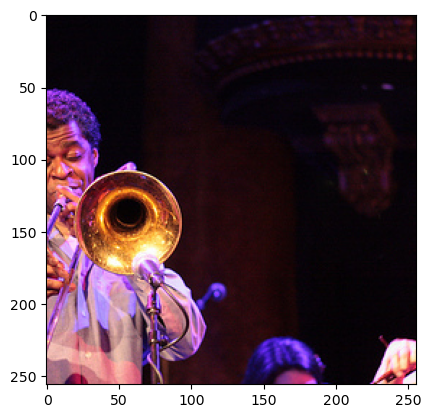

In [22]:
plt.imshow(images[3].permute(1,2,0))

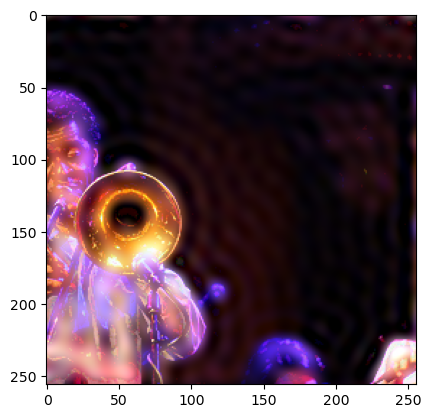

In [23]:
plt.imshow(recon_x[3].permute(1,2,0)) # high_freq 중 특정 계수 이상 가진 애들만 살리니까 이렇게 되는군. 아쉽다.  

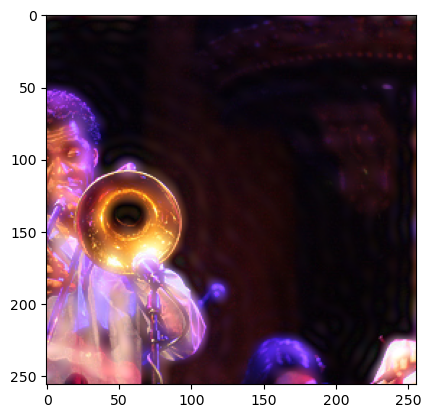

In [25]:
plt.imshow((img_lowpass[3].permute(1,2,0) + img_highpass[3].permute(1,2,0)).clamp(0,1))